Mean Squared Error (MSE) on Testing Data: 3.2898403817788394e-05
Mean Absolute Error (MAE) on Testing Data: 0.004565348472504827
Predicted next value: 570.7527255948024


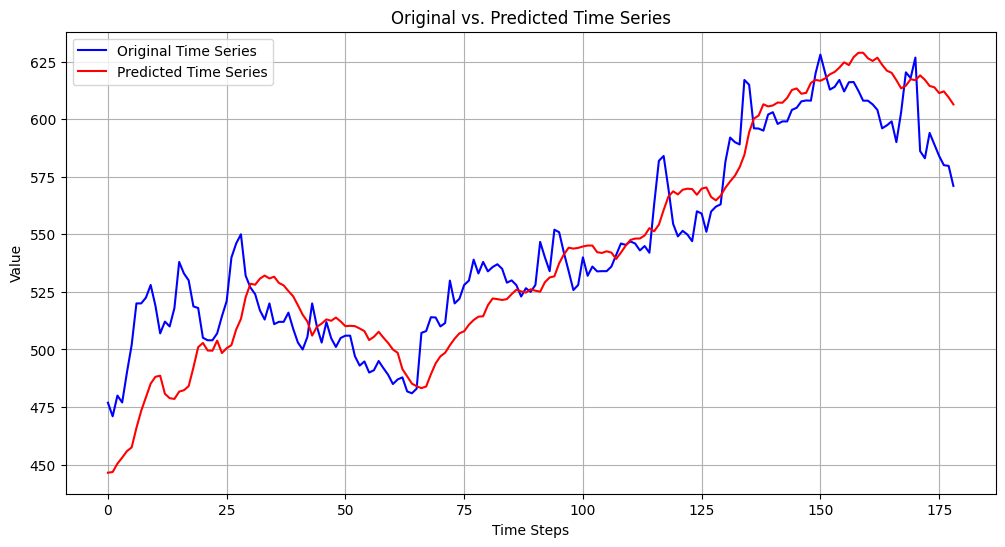

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# Load and preprocess the data
data = pd.read_excel('D:\\Python Project\\EBL_data.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Extract the "Close" column as the target variable
target = data['Close'].values.reshape(-1, 1)

# Normalize the target
scaler = MinMaxScaler()
target_normalized = scaler.fit_transform(target)

# Split the dataset into training and testing sets
train_size = int(len(target_normalized) * 0.9)
train_data = target_normalized[:train_size]
test_data = target_normalized[train_size:]

def prepare_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i+window_size), 0])
        y.append(data[i+window_size, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

window_size = 50

X_train, y_train = prepare_dataset(train_data, window_size)
X_test, y_test = prepare_dataset(test_data, window_size)

class MLP:
    def __init__(self, input_size, hidden_layers, hidden_units, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases for hidden layers and output layer
        self.weights = []
        self.biases = []

        # Initialize weights and biases for the input layer
        self.weights.append(np.random.randn(self.input_size, self.hidden_units))
        self.biases.append(np.zeros((1, self.hidden_units)))

        # Initialize weights and biases for additional hidden layers, if any
        for _ in range(self.hidden_layers - 1):
            self.weights.append(np.random.randn(self.hidden_units, self.hidden_units))
            self.biases.append(np.zeros((1, self.hidden_units)))

        # Initialize weights and biases for the output layer
        self.weights.append(np.random.randn(self.hidden_units, self.output_size))
        self.biases.append(np.zeros((1, self.output_size)))

    def relu(self, x):
        # ReLU activation function
        return np.maximum(0, x)

    # Define the derivative of the ReLU activation function
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def forward(self, x):
        # Forward pass through the MLP
        self.layer_outputs = []
        self.activations = []

        # Input layer
        layer_output = np.array(x)  # Convert input to NumPy array
        self.layer_outputs.append(layer_output)
        self.activations.append(layer_output)

        # Forward pass through hidden layers
        for i in range(self.hidden_layers):
            # Ensure that dimensions match for dot product
            layer_output = np.dot(layer_output, self.weights[i]) + self.biases[i]
            self.layer_outputs.append(layer_output)
            layer_output = self.relu(layer_output)  # Using ReLU activation function
            self.activations.append(layer_output)

        # Output layer
        output = np.dot(layer_output, self.weights[-1]) + self.biases[-1]
        self.layer_outputs.append(output)

        return output

    def backward(self, X, y, predictions):
        # Calculate the gradients using backpropagation
        output_error = y - predictions
        delta = output_error * self.relu_derivative(predictions)

        for i in range(self.hidden_layers, -1, -1):
            if i == self.hidden_layers:
                # Update weights and biases for the output layer
                self.weights[i] += self.learning_rate * np.dot(self.activations[i].T, delta)
                self.biases[i] += self.learning_rate * np.sum(delta, axis=0, keepdims=True)
            else:
                # Update weights and biases for hidden layers
                delta = delta.dot(self.weights[i + 1].T) * self.relu_derivative(self.activations[i])
                self.weights[i] += self.learning_rate * np.dot(self.activations[i].T, delta)
                self.biases[i] += self.learning_rate * np.sum(delta, axis=0, keepdims=True)

        # Update weights and biases for the input layer
        delta = delta.dot(self.weights[0].T) * self.relu_derivative(self.activations[0])
        self.weights[0] += self.learning_rate * np.dot(X.T, delta)
        self.biases[0] += self.learning_rate * np.sum(delta, axis=0, keepdims=True)

    def mse_loss(self, y_true, y_pred):
        # Mean Squared Error (MSE) loss function
        return np.mean((y_true - y_pred) ** 2)

    def train(self, X_train, y_train, X_val, y_val, epochs, patience=10):
        best_loss = float('inf')
        no_improvement_count = 0

        for epoch in range(epochs):
            # Forward pass on training data
            predictions = self.forward(X_train)

            # Calculate MSE loss on training data
            train_loss = self.mse_loss(y_train, predictions)

            # Forward pass on validation data
            val_predictions = self.forward(X_val)

            # Calculate MSE loss on validation data
            val_loss = self.mse_loss(y_val, val_predictions)

            # Print the training and validation loss for monitoring
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

            # Check if validation loss has improved
            if val_loss < best_loss:
                best_loss = val_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # Early stopping: If validation loss hasn't improved for 'patience' epochs, stop training
            if no_improvement_count >= patience:
                print(f"Validation loss hasn't improved for {patience} epochs. Stopping training.")
                break
                
X_train, y_train = prepare_dataset(train_data, window_size)
X_test, y_test = prepare_dataset(test_data, window_size)

# Create an instance of MLPRegressor for prediction
mlp_predictor = MLPRegressor(hidden_layer_sizes=(128, 82), activation='relu', solver='adam', learning_rate_init=0.01, max_iter=1000, random_state=42)

# Ensure that X_train_scaled is defined before fitting the model
X_train_scaled = X_train  # No need for scaling with MinMaxScaler

# Train the predictor on the entire training dataset
mlp_predictor.fit(X_train_scaled, y_train)

# Predict on the test data using the trained MLPRegressor predictor
X_test_scaled = X_test  # No need for scaling with MinMaxScaler
predictions_test = mlp_predictor.predict(X_test_scaled)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate MSE and MAE on testing data
mse_test = mse(y_test, predictions_test)
mae_test = mae(y_test, predictions_test)

print(f"Mean Squared Error (MSE) on Testing Data: {mse_test}")
print(f"Mean Absolute Error (MAE) on Testing Data: {mae_test}")

# Assuming `data` is your original dataset and `window_size` is the window size
recent_data_window = data['Close'].values[-window_size:].reshape(1, -1)

# Predict the next value using the trained MLPRegressor
next_value = mlp_predictor.predict(recent_data_window)
print(f"Predicted next value: {next_value[0]}")

y_test = y_test.reshape(-1,1)
y_test_original = scaler.inverse_transform(y_test)
predictions_test = predictions_test.reshape(-1,1)
predictions_test_original = scaler.inverse_transform(predictions_test)
# Plot the original and predicted time series
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_original)),y_test_original , label="Original Time Series", color='blue')
plt.plot(range(len(predictions_test_original)), predictions_test_original, label="Predicted Time Series", color='red')
plt.title("Original vs. Predicted Time Series")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
